# 1.IMPORT BIBLIOTEK

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2.IMPORT DANYCH

In [130]:
raw_dataset = pd.read_csv('housing_price_dataset.csv')

In [131]:
raw_dataset.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [132]:
raw_dataset.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [133]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


Sprawdzenie ilości duplikatów oraz brakujących wartości

In [134]:
print("ilość duplikatów: ", raw_dataset.duplicated().sum())
print("ilość brakujących", raw_dataset.isnull().sum().sum())


ilość duplikatów:  0
ilość brakujących 0


# 3.Wizualizacja danych

Sprawdzenie rozkładu danych

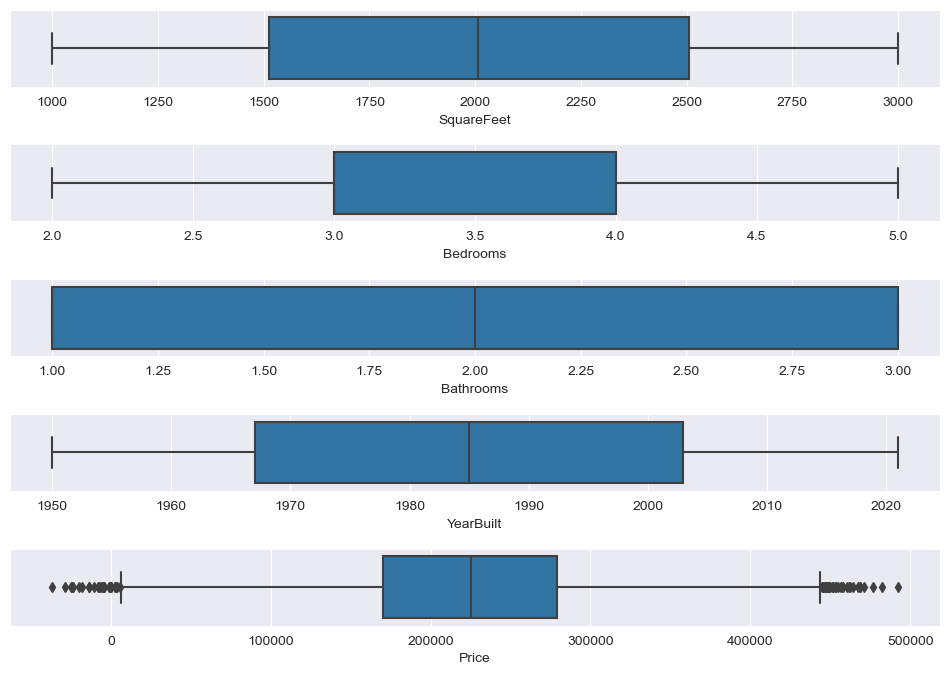

In [135]:
columns_names = ['SquareFeet', 'Bedrooms','Bathrooms','YearBuilt','Price']

fig, ax = plt.subplots(len(columns_names), 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.75)

for i in range(len(columns_names)):
    sns.boxplot(x=columns_names[i], data=raw_dataset, ax=ax[i])

plt.show()

Sprawdzienie unikalnych wartości w każdej kolumnie

In [136]:
for column in raw_dataset.columns:
    num_distinct_values = len(raw_dataset[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

SquareFeet: 2000 distinct values
Bedrooms: 4 distinct values
Bathrooms: 3 distinct values
Neighborhood: 3 distinct values
YearBuilt: 72 distinct values
Price: 50000 distinct values


Wyciągnięcie kolumn numerycznych

In [137]:
df_numericals = raw_dataset.select_dtypes(['int64','float64'])
numericals = [i for i in df_numericals.columns]
print('numericals: ', numericals)

numeric_columns = df_numericals.columns

numericals:  ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'Price']


Sprawdzenie zależności między kolumnami numerycznymi

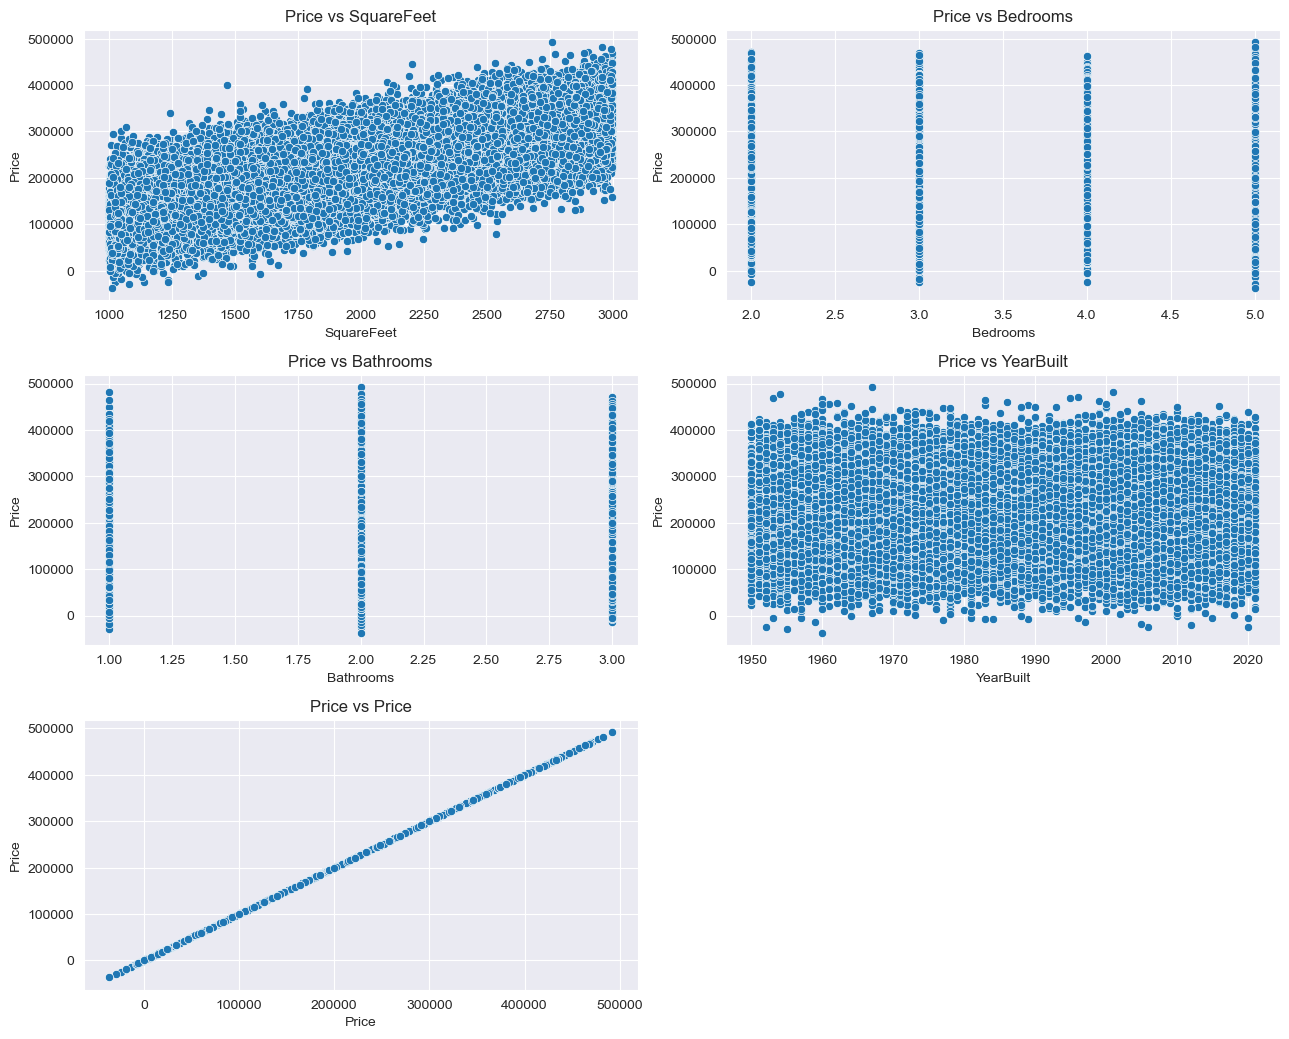

In [138]:
plt.figure(figsize=(13, 17))

for i, variable in enumerate(numeric_columns):
    plt.subplot(5, 2, i + 1)
    sns.scatterplot(x=raw_dataset[variable], y=raw_dataset['Price'])
    plt.title('Price vs ' + variable)
    plt.tight_layout()

plt.show()

Na pierwszy rzut oka możemy zauważyć, że kolumna SquareFeet ma największy wpływ na cenę mieszkania.

Na wykresie cen możemy zauważyć, że niektóre wartości Price przyjmują negatywne wartości. Sprawdźmy ile jest takich wartości.

In [139]:
negative_price_count = raw_dataset[raw_dataset['Price'] < 0].count()['Price']
print("Ilość wartości 'Price' mniejszych od 0: ", negative_price_count)

Ilość wartości 'Price' mniejszych od 0:  22


Zakładamy, że wartości ujemne są błędem i usuwamy je z datasetu. Sprawdzenie rozkładu danych po usunięciu wartości ujemnych

<Axes: xlabel='Price'>

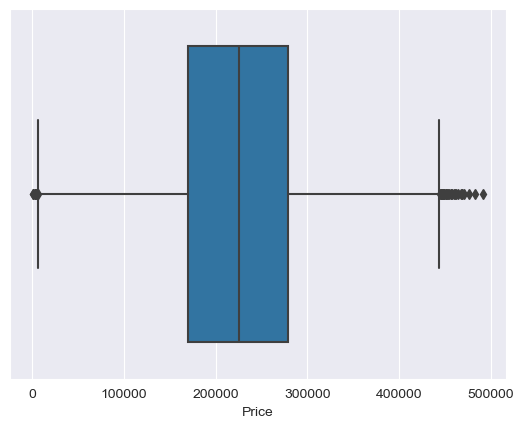

In [140]:
raw_dataset = raw_dataset[raw_dataset['Price'] >= 0]
sns.boxplot(x="Price", data=raw_dataset)

# 4.Przygotowanie i Normalizacja danych

Utworzenie One-Hot Encoding dla kolumny neighbourhood

In [141]:
dataset = raw_dataset.copy()
one_hot = pd.get_dummies(dataset['Neighborhood'], prefix='Neighborhood')
dataset = pd.concat([dataset, one_hot], axis=1)

In [142]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_dataset = train_dataset.reindex(np.random.permutation(train_dataset.index)) # shuffle the examples
test_dataset = dataset.drop(train_dataset.index)

Normalizowanie danych oraz utworzenie warstw preprocessingowych

In [143]:
inputs = {
    'SquareFeet':tf.keras.layers.Input(name='SquareFeet', shape=(1,), dtype='int64'),
    'Bedrooms':tf.keras.layers.Input(name='Bedrooms', shape=(1,), dtype='int64'),
    'Bathrooms':tf.keras.layers.Input(name='Bathrooms', shape=(1,), dtype='int64'),
    'YearBuilt':tf.keras.layers.Input(name='YearBuilt', shape=(1,), dtype='int64'),
}

for column in one_hot.columns:
    inputs[column] = tf.keras.layers.Input(name=column, shape=(1,), dtype='int64')

square_feet = tf.keras.layers.Normalization(name='normalization_square_feet', axis=None)
square_feet.adapt(np.array(train_dataset['SquareFeet']))
square_feet = square_feet(inputs.get('SquareFeet'))

bedrooms = tf.keras.layers.Normalization(name='normalization_bedrooms', axis=None)
bedrooms.adapt(np.array(train_dataset['Bedrooms']))
bedrooms = bedrooms(inputs.get('Bedrooms'))

bathrooms = tf.keras.layers.Normalization(name='normalization_bathrooms', axis=None)
bathrooms.adapt(np.array(train_dataset['Bathrooms']))
bathrooms = bathrooms(inputs.get('Bathrooms'))

year_built = tf.keras.layers.Normalization(name='normalization_year_built', axis=None)
year_built.adapt(np.array(train_dataset['YearBuilt']))
year_built = year_built(inputs.get('YearBuilt'))

preprocessing_layers = tf.keras.layers.Concatenate()(
    [square_feet, bedrooms, bathrooms, year_built])

print("Preprocessing layers defined.")

Preprocessing layers defined.


# 5.Tworzenie modelu

In [144]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [145]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_price_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [146]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_price_normalized = tf.keras.layers.Normalization(axis=None)
train_price_normalized.adapt(
    np.array(train_dataset['Price']))

test_price_normalized = tf.keras.layers.Normalization(axis=None)
test_price_normalized.adapt(
    np.array(test_dataset['Price']))

In [147]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Utworznie modelu regresji liniowej

Epoch 1/15


C:\Users\macie\anaconda3\envs\LaboratoriumPRIAD\Lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['Neighborhood'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/32 [==============================] - 1s 9ms/step - loss: 0.9359 - mean_squared_error: 0.9359 - val_loss: 0.6414 - val_mean_squared_error: 0.6414
Epoch 2/15
32/32 [==============================] - 0s 3ms/step - loss: 0.5277 - mean_squared_error: 0.5277 - val_loss: 0.4614 - val_mean_squared_error: 0.4614
Epoch 3/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4438 - mean_squared_error: 0.4438 - val_loss: 0.4337 - val_mean_squared_error: 0.4337
Epoch 4/15
32/32 [==============================] - 0s 4ms/step - loss: 0.4322 - mean_squared_error: 0.4322 - val_loss: 0.4307 - val_mean_squared_error: 0.4307
Epoch 5/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4313 - mean_squared_error: 0.4313 - val_loss: 0.4306 - val_mean_squared_error: 0.4306
Epoch 6/15
32/32 [==============================] - 0s 4ms/step - loss: 0.4313 - mean_squared_error: 0.4313 - val_loss: 0.4305 - val_mean_squared_error: 0.4305
Epoch 7/15
32/32 [==============================] -

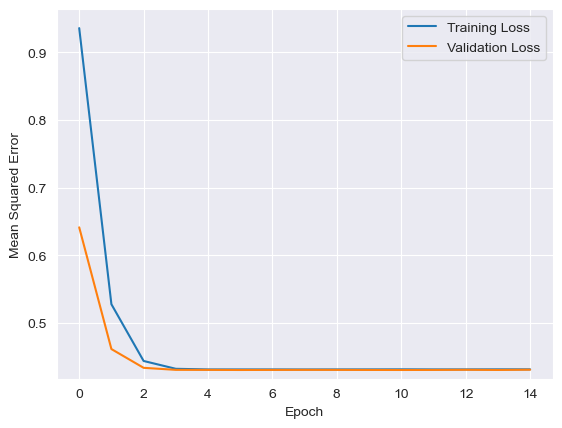


 Evaluate the linear regression model against the test set:
10/10 [==============================] - 0s 2ms/step - loss: 0.4271 - mean_squared_error: 0.4271


{'loss': 0.42711949348449707, 'mean_squared_error': 0.42711949348449707}

In [148]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "Price"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_dataset, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [149]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Utworzenie głebokiej sieci neuronowej

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.5003 - mean_squared_error: 0.5003 - val_loss: 0.4423 - val_mean_squared_error: 0.4423
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4364 - mean_squared_error: 0.4364 - val_loss: 0.4351 - val_mean_squared_error: 0.4351
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4350 - mean_squared_error: 0.4350 - val_loss: 0.4356 - val_mean_squared_error: 0.4356
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4336 - mean_squared_error: 0.4336 - val_loss: 0.4335 - val_mean_squared_error: 0.4335
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.4334 - mean_squared_error: 0.4334 - val_loss: 0.4339 - val_mean_squared_error: 0.4339
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4328 - mean_squared_error: 0.4328 - val_loss: 0.4334 - val_mean_squared_error: 0.4334
Epoch 7/20
32/32 [======================

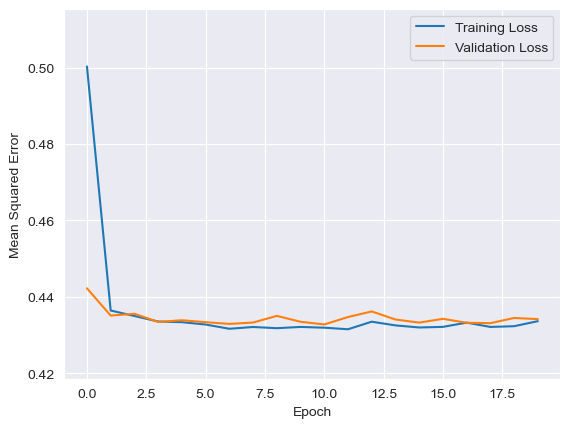


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 2ms/step - loss: 0.4285 - mean_squared_error: 0.4285


{'loss': 0.42847374081611633, 'mean_squared_error': 0.42847374081611633}

In [150]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "Price"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_dataset, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/programming-exercise?hl=en

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en

https://www.kaggle.com/code/alkidiarete/housing-price-prediction-h2o-ai-automl/notebook

https://www.tensorflow.org/tutorials/keras/regression?hl=pl